In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tqdm import tqdm
import pickle
from sklearn.decomposition import PCA
from scipy.spatial import distance
import random
from sklearn.metrics import roc_curve, auc
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [29]:
def group_median(table):
    table_ = copy.copy(table)
    col_list = list(table_.columns)
    median_series = np.nanmedian(table_, axis=0)
    median_factor_series = median_series / np.median(median_series)
    median_factor_list = list(median_factor_series)
    for i in range(len(median_factor_list)):
        table_[col_list[i]] = table[col_list[i]] / median_factor_list[i]
    return table_

def table_median(table,s,m,n): # 从table的第s列开始校正，有m组数据，每组n次重复
    group_lst = []
    group_lst.append(table.iloc[:,:s])
    for i in range(m):
        s_new = s + i*n
        table_group = table.iloc[:,s_new:s_new+n]
        group_lst.append(group_median(table_group))
    table_new = pd.concat(group_lst, axis=1)
    return table_new

def correlation_plot(table,x,y,xlabel,ylabel):
    a = table[[x]].astype('float')
    b = table[[y]].astype('float')
    z = np.corrcoef(a[x],b[y])
    score = z[0,1]
    plt.figure(figsize=(4,4))
    plt.title('Correlation of '+xlabel+' and '+ylabel,fontsize = 16,pad=15)
    plt.xlabel(xlabel,fontsize=15,labelpad=10)
    plt.ylabel(ylabel,fontsize=15,labelpad=10)
    plt.scatter(table[x], table[y],color='steelblue',alpha=0.3)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.text(min(table[x]),min(table[y])-(max(table[y])-min(table[y]))/2.5,
             'Pearson coefficient: ' + str(round(score,4)),fontsize=15,color='black')
def dist(table, method='cityblock'): # Distance between every two proteins
    table_values = tuple(table.iloc[:,2:].values)
    dist_matrix = pd.DataFrame(distance.cdist(table_values, table_values, metric=method), index=table.iloc[:,0], columns = table.iloc[:,0])
    dist_matrix.index.name = ''
    dist_matrix.columns.name = ''
    return round(dist_matrix,6)

def pair_found(table, pair_table): # Based on the protein pair interaction Database, look for protein pairs where both proteins appear in the data
    list_pro = list(table.iloc[:,0])
    pair_table_found = pair_table[np.array([pair_table.iloc[:,0][i] in list_pro for i in range(len(pair_table))]) & 
                                  np.array([pair_table.iloc[:,1][i] in list_pro for i in range(len(pair_table))])].reset_index(drop=True)
    return pair_table_found

def roc(table, pair_table, method='cityblock'): # Calculate parameters of the ROC curve
    pair_table_found = pair_found(table, pair_table)
    dist_matrix = dist(table, method)
    roc_label, roc_score = [], []
    for i in range(len(pair_table_found)): # The distance of positive protein pairs in the data
        pro_a, pro_b = pair_table_found.iloc[i,0], pair_table_found.iloc[i,1]
        roc_score.append(-1 * dist_matrix.loc[pro_a,pro_b]) # Extract distance of positive pairs
        roc_label.append(1) # Positive labels
        dist_matrix.loc[pro_a, pro_b], dist_matrix.loc[pro_b, pro_a] = 0,0 # Zero out the extracted positive distance
    neg_values = np.triu(dist_matrix, k=0).flatten() 
    neg_values = neg_values[neg_values!=0] # Extract distance of negative pairs
    random.seed(42)
    roc_score += list(-1 * np.array(random.sample(list(neg_values),100000))) # Mix 100,000 negative protein pairs randomly in the distance of positive protein pairs
    roc_label += [0] * 100000 # Mix 100,000 negative labels
    fpr,tpr,threshold = roc_curve(roc_label, roc_score, pos_label = 1) # Calculate false positive rate, true positive rate, threshold
    roc_auc = auc(fpr,tpr) # Calculate area under curve
    return fpr, tpr, round(roc_auc,4)

def roc_plot(table, pair_table, title, method='cityblock'): # Draw ROC plot based on parameters
    fpr, tpr, roc_auc = roc(table, pair_table, method)
    plt.figure(figsize=(3,3))
    plt.plot(fpr, tpr, label='AUC={}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc=4, fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()

def two_from_set(list_):
    two_list = []
    for i in range(len(list_)):
        for j in range(i+1,len(list_)):
            two_list_ =[list_[i],list_[j]]
            two_list.append(two_list_)
    return two_list

def asign_multi_series_to_df(series_list,col_list):
    series_list_ = copy.copy(series_list)
    df = pd.DataFrame()
    max_len = max([len(i) for i in series_list])
    
    for i in tqdm(range(len(series_list))):
        series_ = series_list[i]
        if len(series_)<max_len:
            series_ = list(series_)
            series_.extend([np.nan]*(max_len-len(series_)))
            df[col_list[i]] = series_
        else:
            df[col_list[i]] = series_
    return df

def dist(table, method='cityblock'): # Distance between every two proteins
    table_values = tuple(table.iloc[:,2:].values)
    dist_matrix = pd.DataFrame(distance.cdist(table_values, table_values, metric=method), index=table.iloc[:,0], columns = table.iloc[:,0])
    dist_matrix.index.name = ''
    dist_matrix.columns.name = ''
    return round(dist_matrix,6)

def pair_found(table, pair_table): # Based on the protein pair interaction Database, look for protein pairs where both proteins appear in the data
    list_pro = list(table.iloc[:,0])
    pair_table_found = pair_table[np.array([pair_table.iloc[:,0][i] in list_pro for i in range(len(pair_table))]) & 
                                  np.array([pair_table.iloc[:,1][i] in list_pro for i in range(len(pair_table))])].reset_index(drop=True)
    return pair_table_found

def complex_found(table, complex_table):
    complex_out = copy.copy(complex_table)
    sub_found, num_sub_found = [], []
    for i in range(len(complex_out)):
        l_sub = complex_out['subunits(UniProt IDs)'][i].split(';')
        l_found = [sub for sub in l_sub if sub in list(table.iloc[:,0])] # Subunit proteins found in the data
        sub_found.append(';'.join(l_found))
        num_sub_found.append(len(l_found)) # Number of subunit proteins found in the data
    complex_out['Subunit_Found'] = sub_found
    complex_out['No_Subunit_Found'] = num_sub_found
    complex_out = complex_out[complex_out['No_Subunit_Found']>=2].reset_index(drop=True) # Complexes with at least 3 subunit proteins
    return complex_out

def complex_dist(table, complex_table, method='cityblock'): # The average distance between the subunit proteins of the complex
    complex_table_found = complex_found(table, complex_table)
    dist_matrix = dist(table, method)
    l_dist = []
    for i in range(len(complex_table_found)):
        l_sub = complex_table_found['Subunit_Found'][i].split(';')
        sub_matrix = dist_matrix.loc[l_sub, l_sub]
        avg_dist = np.nanmean(sub_matrix.replace(0, np.nan)) # The average distance between the subunit proteins of the complex
        l_dist.append(avg_dist)
    complex_table_found['Avg_Dist'] = l_dist
    complex_table_found['Avg_Dist_Derived'] = 1 / (1+np.array(l_dist)) # Data normalization as 1/(1+x) to make the data closer to a normal distribution
    return complex_table_found

def random_n(table, complex_table, method='cityblock', samplesize=10000): # Sample virtual random complexes for calculation
    l_n = list(set(complex_found(table, complex_table)['No_Subunit_Found'])) # n is the size of the complex
    l_n.sort()
    dic_out = {}
    pairs_dist_table = dist(table, method)
    pairs_dist_table = pairs_dist_table.replace(0, np.nan)
    for num in tqdm(l_n): # For each size n, virtual random complexes with the same size are sampled
        l_n_dist = []
        random.seed(42)
        for i in range(samplesize):
            random_proteins = random.sample(list(pairs_dist_table.index), num)
            random_sub_table = pairs_dist_table.loc[random_proteins, random_proteins]
            l_n_dist.append(np.nanmean(random_sub_table)) # Calculate the average distance of virtual random complexes
        dic_out[num] = l_n_dist
    return dic_out

def complex_signature_sample(table, complex_table, method='cityblock', samplesize=10000): # Calculate TPCA signatures of complexes by sampling
    complex_table_found = complex_dist(table, complex_table)
    dic_random = random_n(table, complex_table, method, samplesize)
    p_value, z_score = [], []
    for i in range(len(complex_table_found)):
        n = complex_table_found['No_Subunit_Found'][i]
        avg_dist = complex_table_found['Avg_Dist'][i]
        avg_dist_derived = complex_table_found['Avg_Dist_Derived'][i]
        l_random_n = dic_random[n] # Average distance of virtual random complexes with size n
        l_random_n_derived = list(1/(1+np.array(l_random_n))) + [avg_dist_derived]
        p_value.append(np.sum(np.array(l_random_n)<avg_dist)/samplesize) # Proportion of the average distance in the putative complexes smaller than those of random complexes
        z_score.append(stats.zscore(l_random_n_derived)[-1]) # Can also be expressed as a z-score.
    complex_table_found['TPCA_Sig_P-value'] = p_value
    complex_table_found['TPCA_Sig_Z-score'] = z_score
    random_table = pd.DataFrame(dic_random)
    return random_table, complex_table_found

In [3]:
# ----------catalog----------
# Because the paper has not yet been published, the data in source_data(source_catalog) has not 
# yet been uploaded,if you need it, 
# you can contact the authors of the paper or contact the authors of the repository on github to get it.
article_catalog='article_data\\'
source_catalog='source_data\\'
database_catalog='database_data\\'
# ----------catalog----------

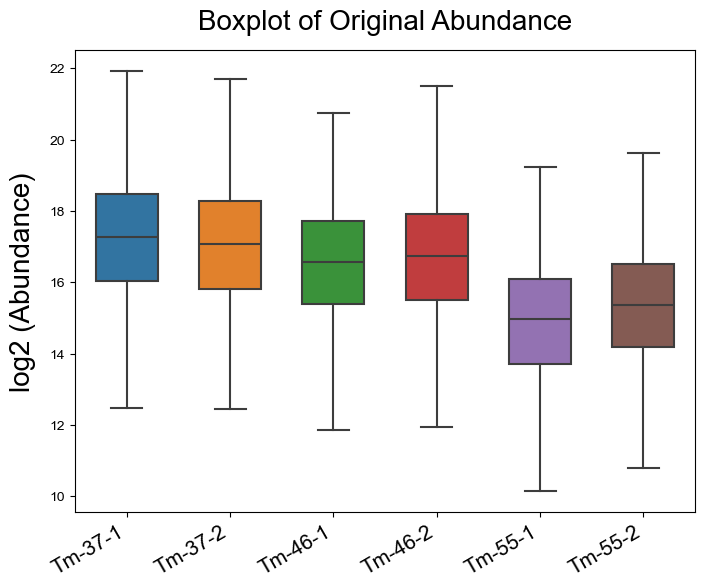

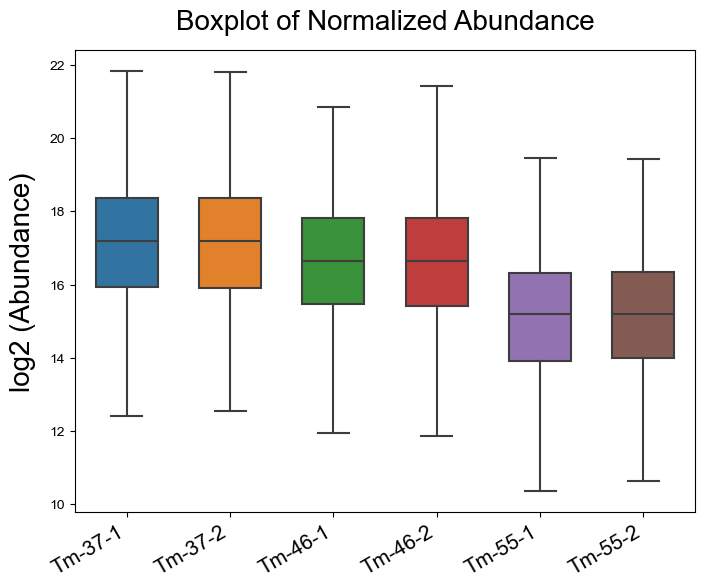

In [4]:
# Analysis of the thermal stability data obtained with Mito-TPCA to assess the predictability of mitochondrial interacting protein pairs

# 1. Abundances of proteins

# Original data
TPCA_293T_table = pd.read_excel(source_catalog + 'Mito-TPCA-293t.xlsx')
TPCA_293T_table.index = TPCA_293T_table['Uniprot ID']
group_info = list(TPCA_293T_table.columns[6:-1])

# draw the boxplot
plt.figure(figsize=(8, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
sns.boxplot(data=np.log2(TPCA_293T_table.iloc[:,6:-1]), showfliers=False,width=0.6)
plt.xticks(rotation=30, ha='right',fontsize=15)
plt.title('Boxplot of Original Abundance', fontsize=20,pad=15)
plt.ylabel('log2 (Abundance)',fontsize=20,labelpad=10) 
plt.show()

# Normalized data
TPCA_293T_table_m_ = table_median(TPCA_293T_table,6,3,2)
TPCA_293T_table_m = pd.concat([TPCA_293T_table_m_,TPCA_293T_table.iloc[:,[-1]]],axis=1)

# draw the boxplot
plt.figure(figsize=(8, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
sns.boxplot(data=np.log2(TPCA_293T_table_m.iloc[:,6:-1]), showfliers=False,width=0.6)
plt.xticks(rotation=30, ha='right',fontsize=15)
plt.title('Boxplot of Normalized Abundance', fontsize=20,pad=15)
plt.ylabel('log2 (Abundance)',fontsize=20,labelpad=10) 
plt.show()

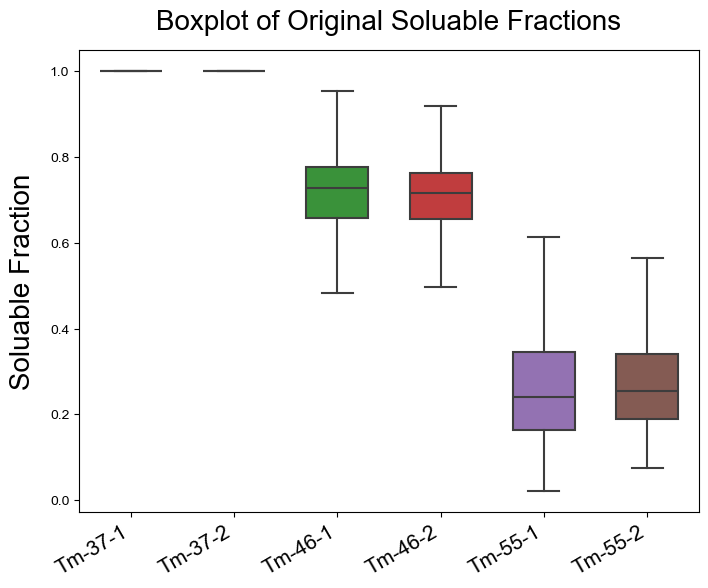

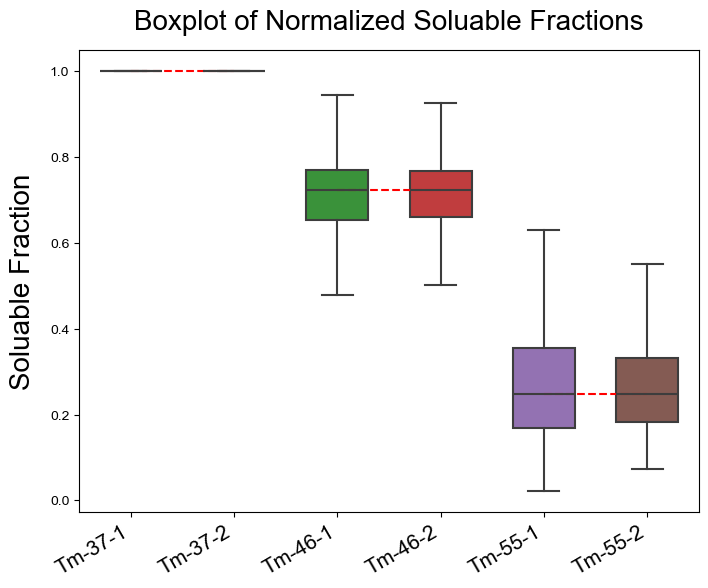

In [5]:
# 2. Soluable fractions of proteins

# Original data
TPCA_293T_table_f = copy.copy(TPCA_293T_table)

TPCA_293T_table_f['Tm-37-1'] = TPCA_293T_table_m['Tm-37-1']/TPCA_293T_table_m['Tm-37-1']
TPCA_293T_table_f['Tm-46-1'] = TPCA_293T_table_m['Tm-46-1']/TPCA_293T_table_m['Tm-37-1']
TPCA_293T_table_f['Tm-55-1'] = TPCA_293T_table_m['Tm-55-1']/TPCA_293T_table_m['Tm-37-1']

TPCA_293T_table_f['Tm-37-2'] = TPCA_293T_table_m['Tm-37-2']/TPCA_293T_table_m['Tm-37-2']
TPCA_293T_table_f['Tm-46-2'] = TPCA_293T_table_m['Tm-46-2']/TPCA_293T_table_m['Tm-37-2']
TPCA_293T_table_f['Tm-55-2'] = TPCA_293T_table_m['Tm-55-2']/TPCA_293T_table_m['Tm-37-2']

# filtering the proteins of soluable fraction>1.2
for group in group_info:
    TPCA_293T_table_f = TPCA_293T_table_f[TPCA_293T_table_f[group]<1.2]

# draw the boxplot
plt.figure(figsize=(8, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
sns.boxplot(data=TPCA_293T_table_f.iloc[:,6:-1], showfliers=False,width=0.6)
plt.xticks(rotation=30, ha='right',fontsize=15)
plt.title('Boxplot of Original Soluable Fractions', fontsize=20,pad=15)
plt.ylabel('Soluable Fraction',fontsize=20,labelpad=10) 
plt.show()

# Normalized data
TPCA_293T_table_f_m_ = table_median(TPCA_293T_table_f,6,3,2)
TPCA_293T_table_f_m = pd.concat([TPCA_293T_table_f_m_,TPCA_293T_table_f.iloc[:,[-1]]],axis=1)

median_fraction_37 = np.median(TPCA_293T_table_f_m[['Tm-37-1','Tm-37-2']],axis=0)[0]
median_fraction_46 = np.median(TPCA_293T_table_f_m[['Tm-46-1','Tm-46-2']],axis=0)[0]
median_fraction_55 = np.median(TPCA_293T_table_f_m[['Tm-55-1','Tm-55-2']],axis=0)[0]

# draw the boxplot
plt.figure(figsize=(8, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
sns.boxplot(data=TPCA_293T_table_f_m.iloc[:,6:-1], showfliers=False,width=0.6)
plt.xticks(rotation=30, ha='right',fontsize=15)
plt.title('Boxplot of Normalized Soluable Fractions', fontsize=20,pad=15)
plt.ylabel('Soluable Fraction',fontsize=20,labelpad=10) 
plt.plot([0,1],[median_fraction_37,median_fraction_37],ls = '--', color = 'red')
plt.plot([2,3],[median_fraction_46,median_fraction_46],ls = '--', color = 'red')
plt.plot([4,5],[median_fraction_55,median_fraction_55],ls = '--', color = 'red')


Text(0.5, 1.0, 'PCA analysis (Soluable fractions)')

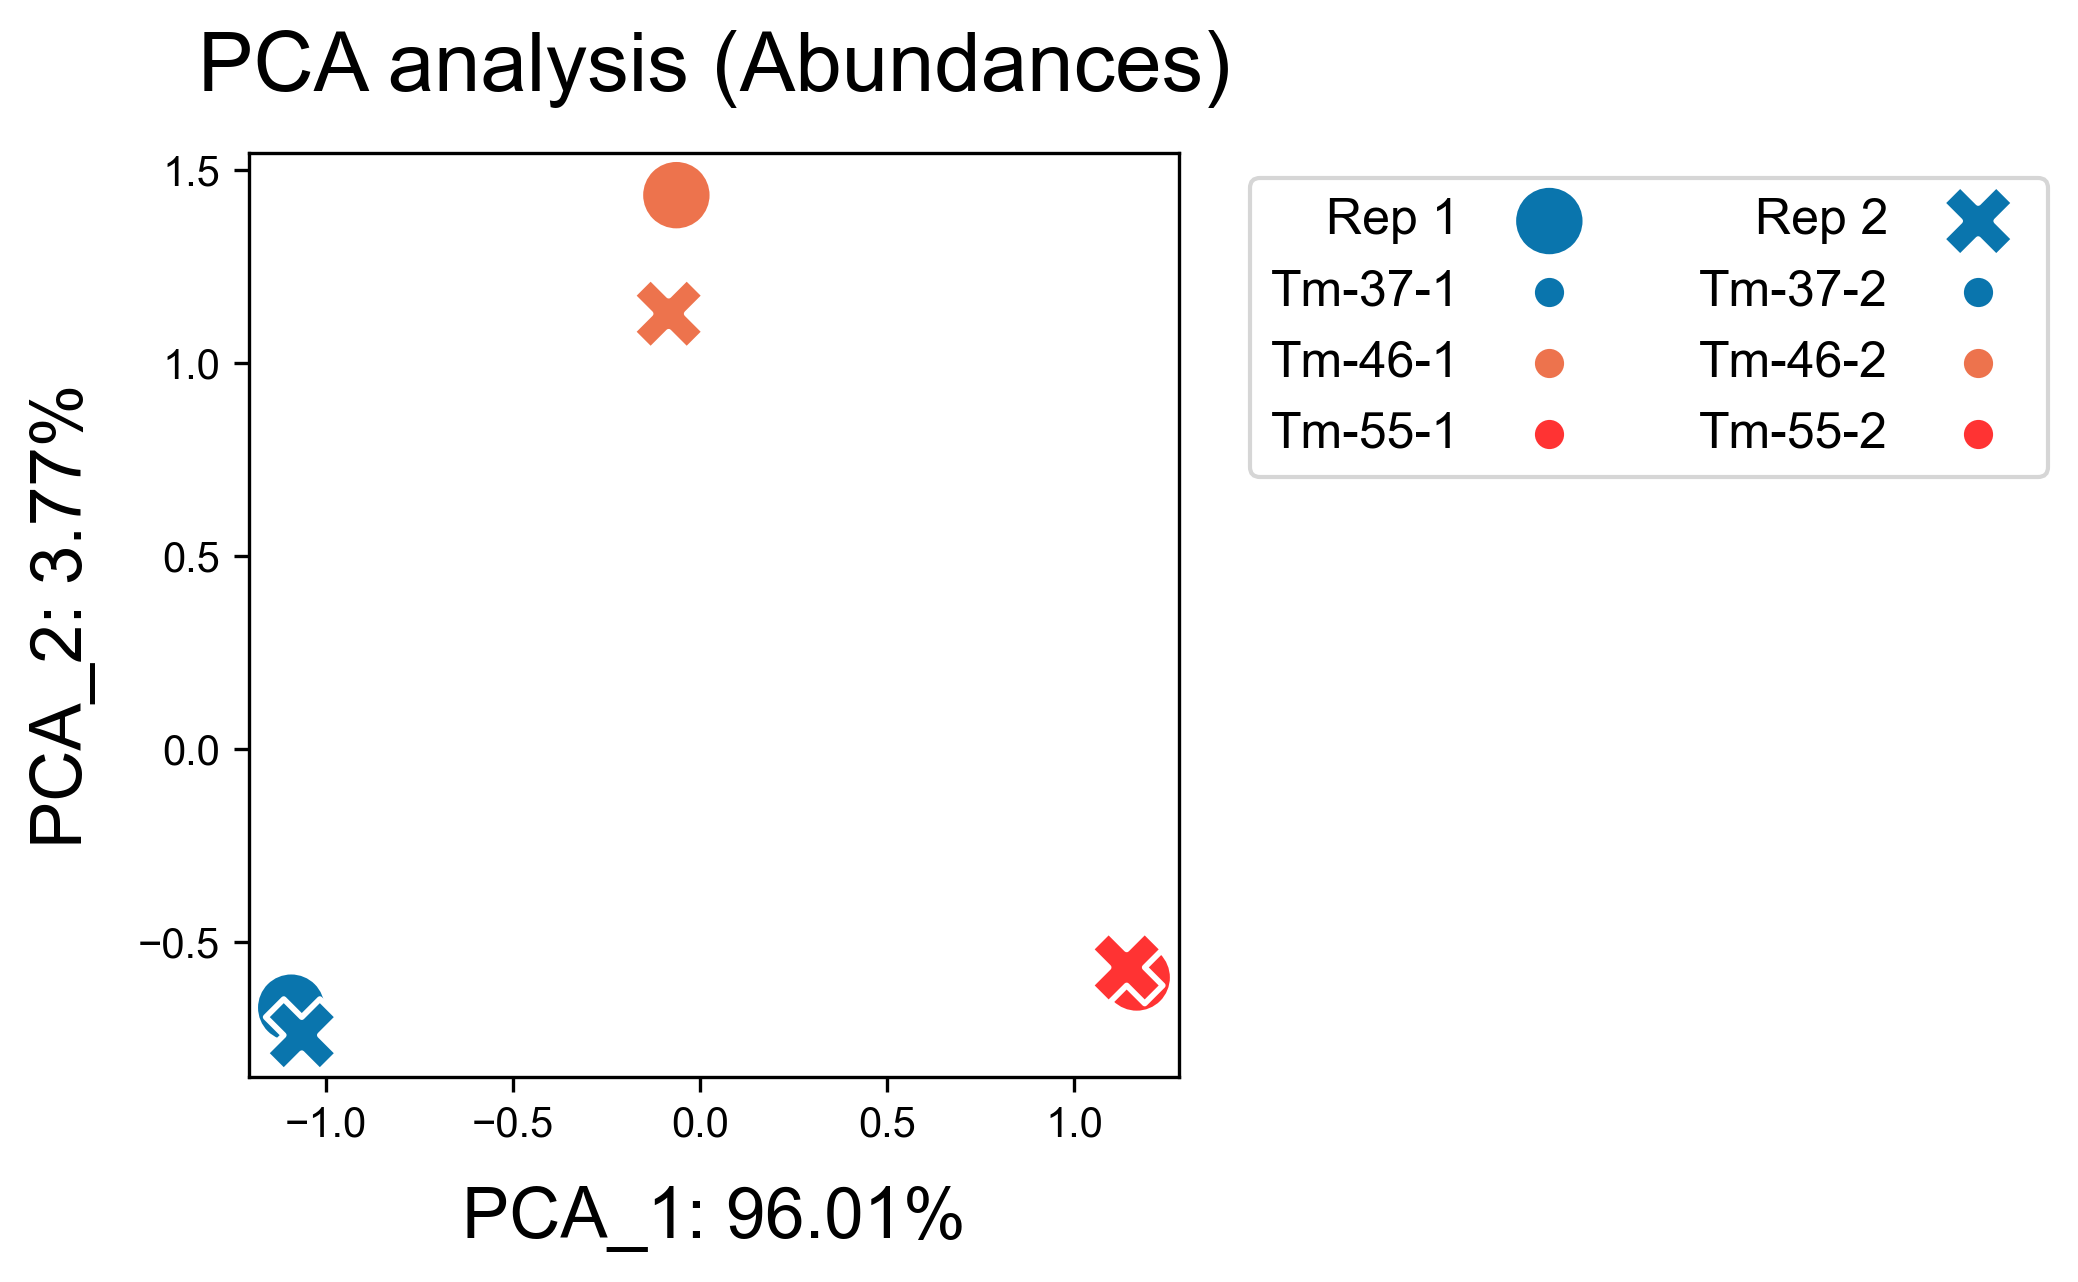

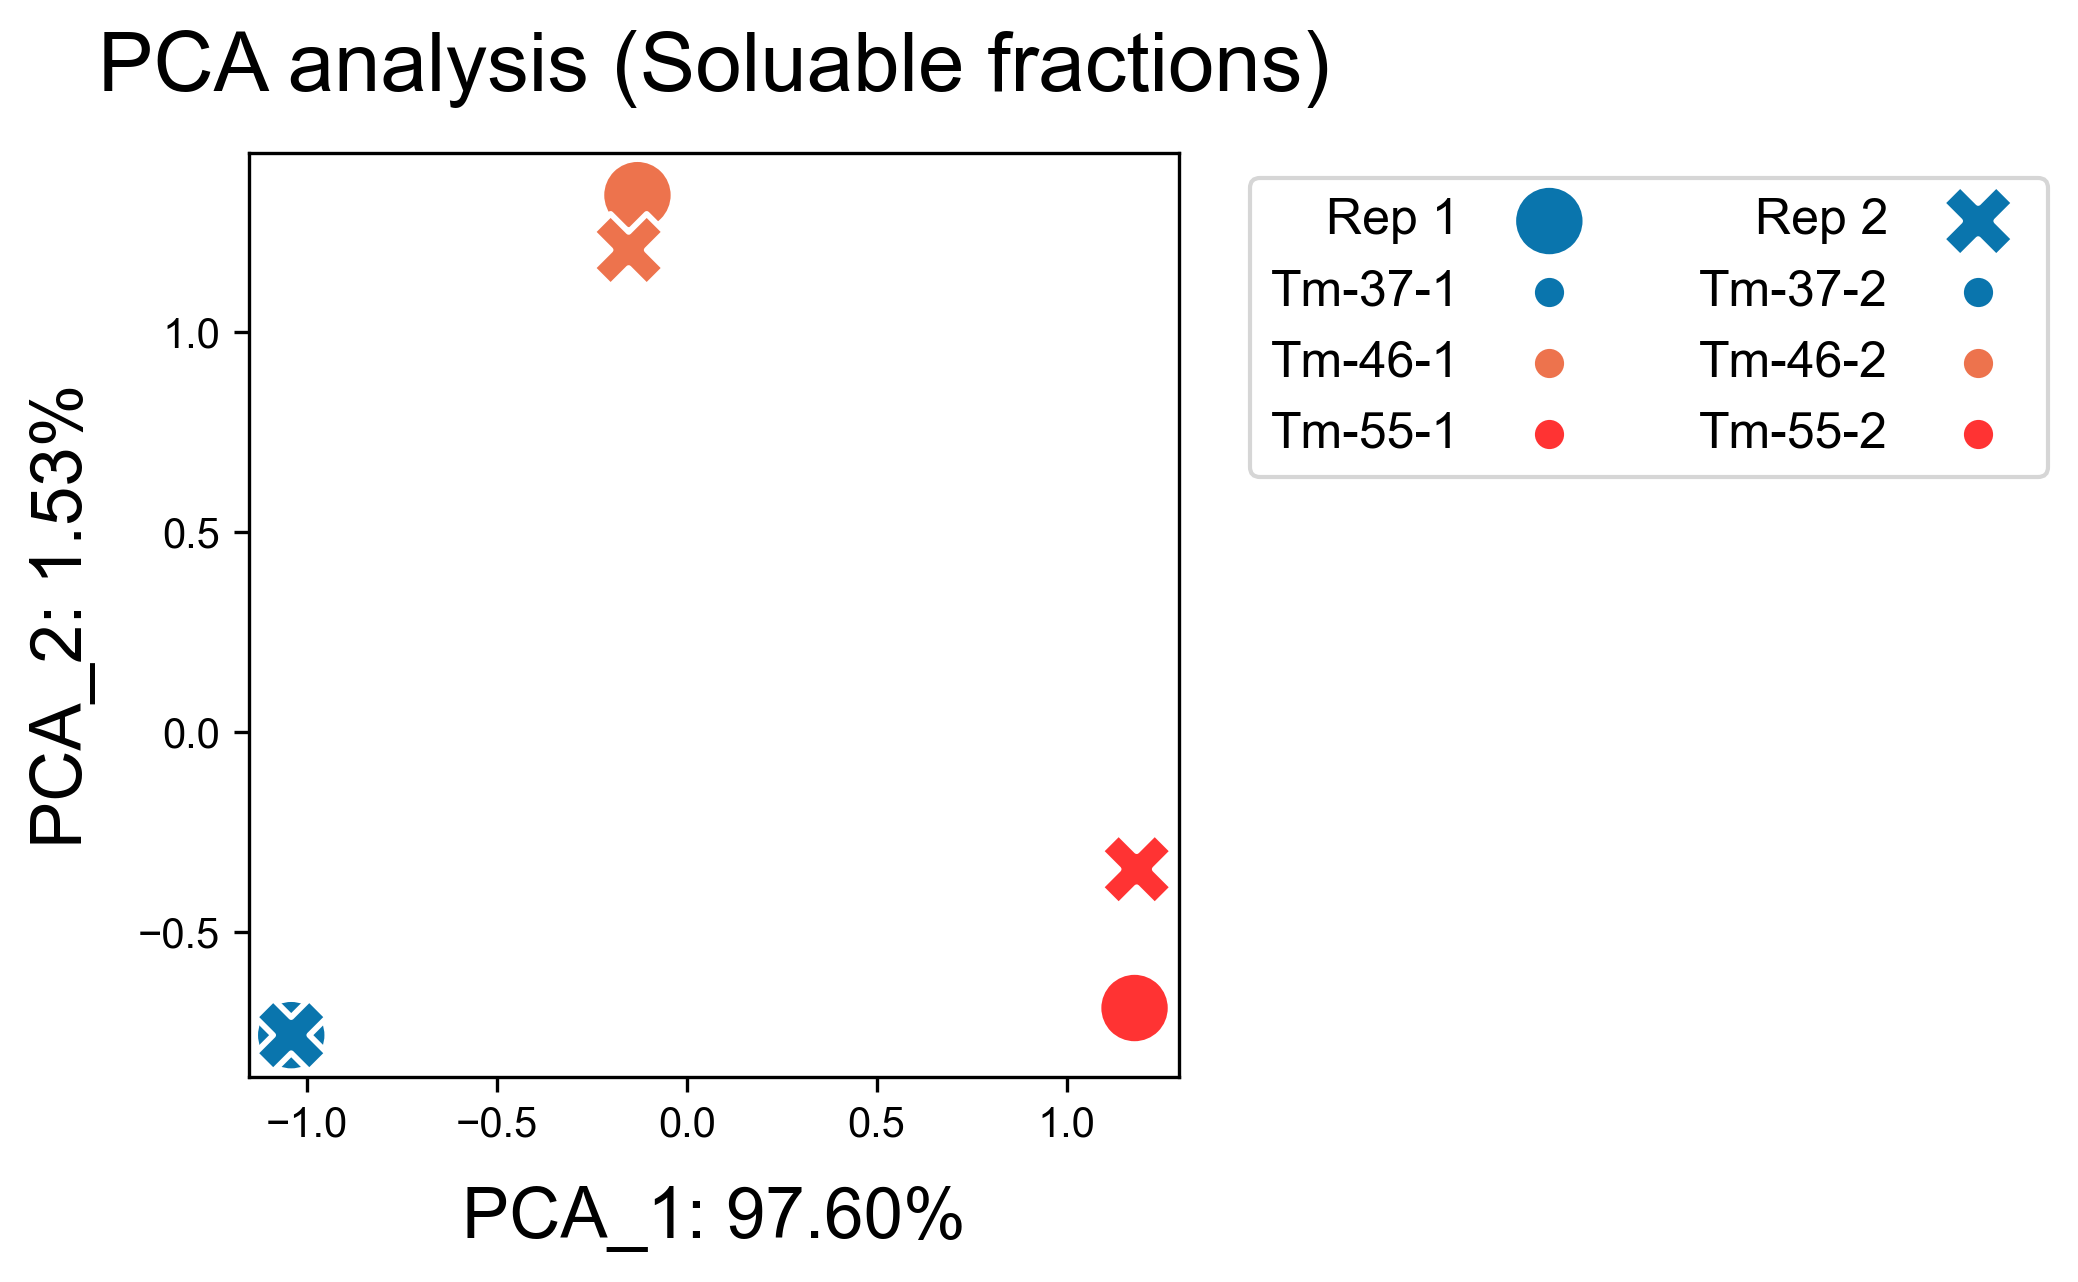

In [6]:
# 3. PCA analysis

blue = ['#0a75ad']
orange = ['#ed734d']
red = ['#ff3333']
color = blue + orange + red
marker_dict = {'rep_1':'o','rep_2':'X'}

m = 0.99
pca = PCA(n_components=m, whiten=True)

# Abundances of proteins
data_PCA = TPCA_293T_table_m.iloc[:,6:-1]
data_PCA_ = data_PCA.T
reduced_data = pd.DataFrame(pca.fit_transform(data_PCA_))
reduced_data = reduced_data.iloc[:,[0,1]]
reduced_data.columns=['PCA_{:}'.format(i) for i in range(1,3)]
reduced_data['group_info'] = data_PCA.columns
x,y = pca.explained_variance_ratio_[:2]

# draw scatter plot
plt.figure(dpi=300,figsize=(4,4))
ax1 = sns.scatterplot(data=reduced_data.iloc[[0,2,4],:],x='PCA_1',y='PCA_2',hue='group_info',marker='o',palette=color,s=300,label='Rep 1')
ax2 = sns.scatterplot(data=reduced_data.iloc[[1,3,5],:],x='PCA_1',y='PCA_2',hue='group_info',marker='X',palette=color,s=300,label='Rep 2')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),fontsize=12,markerfirst=False,markerscale=1,scatterpoints=1,ncol=2)
plt.xlabel('PCA_1: {:.2f}%'.format(x*100),fontsize=17,labelpad=10)
plt.ylabel('PCA_2: {:.2f}%'.format(y*100),fontsize=17,labelpad=10)
plt.title('PCA analysis (Abundances)',fontsize=20,pad=15)

# Soluable fractions of proteins
data_PCA = TPCA_293T_table_f_m.iloc[:,6:-1]
data_PCA_ = data_PCA.T
reduced_data = pd.DataFrame(pca.fit_transform(data_PCA_))
reduced_data = reduced_data.iloc[:,[0,1]]
reduced_data.columns=['PCA_{:}'.format(i) for i in range(1,3)]
reduced_data['group_info'] = data_PCA.columns
x,y = pca.explained_variance_ratio_[:2]

# draw scatter plot
plt.figure(dpi=300,figsize=(4,4))
ax1 = sns.scatterplot(data=reduced_data.iloc[[0,2,4],:],x='PCA_1',y='PCA_2',hue='group_info',marker='o',palette=color,s=300,label='Rep 1')
ax2 = sns.scatterplot(data=reduced_data.iloc[[1,3,5],:],x='PCA_1',y='PCA_2',hue='group_info',marker='X',palette=color,s=300,label='Rep 2')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),fontsize=12,markerfirst=False,markerscale=1,scatterpoints=1,ncol=2)
plt.xlabel('PCA_1: {:.2f}%'.format(x*100),fontsize=17,labelpad=10)
plt.ylabel('PCA_2: {:.2f}%'.format(y*100),fontsize=17,labelpad=10)
plt.title('PCA analysis (Soluable fractions)',fontsize=20,pad=15)

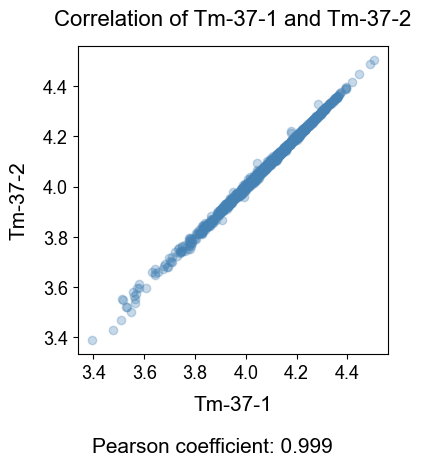

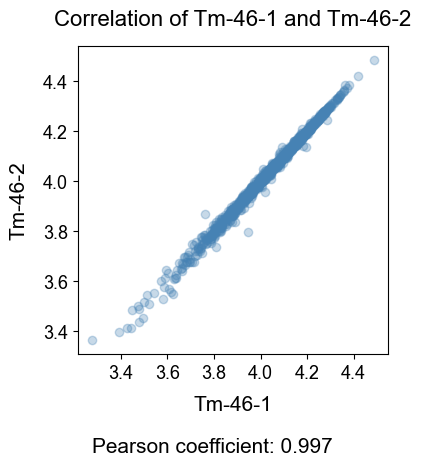

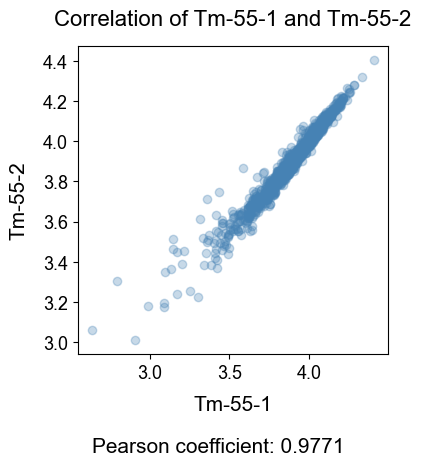

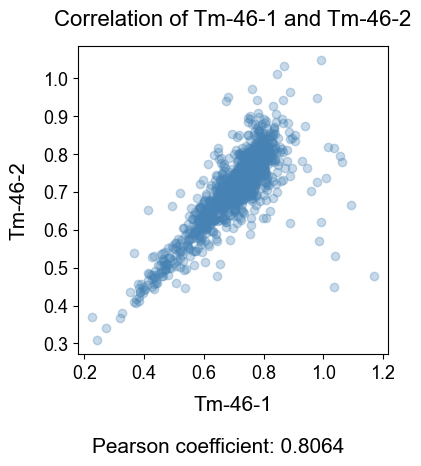

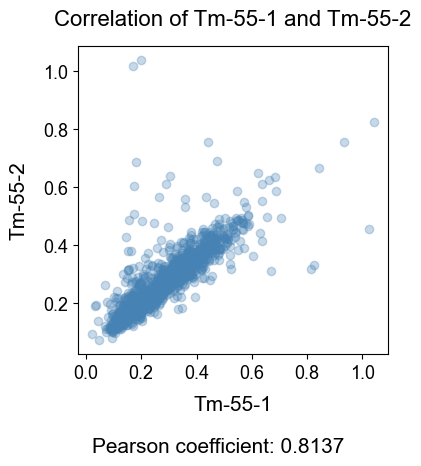

In [7]:
# 4. Correlation analysis between two replicates

# Abundances of proteins
table_cor_37 = TPCA_293T_table_m.loc[:,['Tm-37-1','Tm-37-2']].apply(lambda x: np.log2(x))
table_cor_46 = TPCA_293T_table_m.loc[:,['Tm-46-1','Tm-46-2']].apply(lambda x: np.log2(x))
table_cor_55 = TPCA_293T_table_m.loc[:,['Tm-55-1','Tm-55-2']].apply(lambda x: np.log2(x))

correlation_plot(np.log2(table_cor_37),'Tm-37-1','Tm-37-2','Tm-37-1','Tm-37-2')
correlation_plot(np.log2(table_cor_46),'Tm-46-1','Tm-46-2','Tm-46-1','Tm-46-2')
correlation_plot(np.log2(table_cor_55),'Tm-55-1','Tm-55-2','Tm-55-1','Tm-55-2')

# Soluable fractions of proteins
table_cor_f_46 = TPCA_293T_table_f_m.loc[:,['Tm-46-1','Tm-46-2']]
table_cor_f_55 = TPCA_293T_table_f_m.loc[:,['Tm-55-1','Tm-55-2']]

correlation_plot(table_cor_f_46,'Tm-46-1','Tm-46-2','Tm-46-1','Tm-46-2')
correlation_plot(table_cor_f_55,'Tm-55-1','Tm-55-2','Tm-55-1','Tm-55-2')

In [8]:
# 5. Combine data of two replicates
TPCA_293T_table_m_combine = copy.copy(TPCA_293T_table_m)
TPCA_293T_table_m_combine['Tm-37'] = np.mean(TPCA_293T_table_m[['Tm-37-1','Tm-37-2']],axis=1)
TPCA_293T_table_m_combine['Tm-46'] = np.mean(TPCA_293T_table_m[['Tm-46-1','Tm-46-2']],axis=1)
TPCA_293T_table_m_combine['Tm-55'] = np.mean(TPCA_293T_table_m[['Tm-55-1','Tm-55-2']],axis=1)

TPCA_293T_table_m_combine['Gene'] = [i.split(' ')[0] for i in TPCA_293T_table_m_combine['Gene Names'].to_list()]
TPCA_293T_table_m_combine = TPCA_293T_table_m_combine.rename(columns={'Uniprot ID':'Accession'})

TPCA_293T_table_m_combine = TPCA_293T_table_m_combine.loc[:,['Accession','Gene','Tm-37','Tm-46','Tm-55','Mito']]

data_direct = copy.copy(TPCA_293T_table_m_combine)
data_direct['Tm-37'] = TPCA_293T_table_m_combine['Tm-37']/TPCA_293T_table_m_combine['Tm-37']
data_direct['Tm-46'] = TPCA_293T_table_m_combine['Tm-46']/TPCA_293T_table_m_combine['Tm-37']
data_direct['Tm-55'] = TPCA_293T_table_m_combine['Tm-55']/TPCA_293T_table_m_combine['Tm-37']

# filtering the proteins of soluable fraction>1.2
for group in ['Tm-37','Tm-46','Tm-55']:
    data_direct = data_direct[data_direct[group]<1.2].reset_index(drop=True)

In [23]:
# 6. Mito-PPI database reading
pair_db = pd.read_excel(source_catalog + 'Supplementary Table 1_PPI database.xlsx')
pair_db['subunits(UniProt IDs)'] = ['{};{}'.format(pair_db.loc[i,'Protein A'],pair_db.loc[i,'Protein B']) for i in pair_db.index]

pair_1 = pair_db[pair_db['No. of Publications']>=1].reset_index(drop=True)
pair_2 = pair_db[pair_db['No. of Publications']>=2].reset_index(drop=True)
pair_3 = pair_db[pair_db['No. of Publications']>=3].reset_index(drop=True)
pair_4 = pair_db[pair_db['No. of Publications']>=4].reset_index(drop=True)

mito_genes = list(data_direct[data_direct['Mito'].isna()==False]['Accession'])
data_mito = data_direct[data_direct['Accession'].isin(mito_genes)]

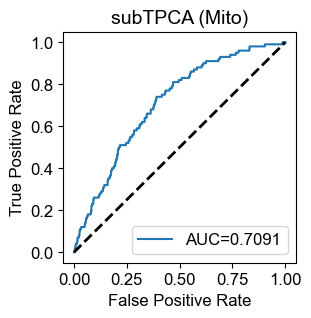

In [10]:
# 7. ROC curve analysis
roc_plot(data_mito.iloc[:,:-1], pair_3,'subTPCA (Mito)')

In [13]:
# 8. Distribution of Manhattan distance among known interacting protein pairs according to number of reporting publications: PMID (PubMed identifier)
pair_all_list = two_from_set(mito_genes)
pair_all = pd.DataFrame()
n = 0
for i in tqdm(pair_all_list):
    pair_all.loc[n,'subunits(UniProt IDs)'] = ';'.join(i)
    n = n + 1
#pair_all = pickle.load(open(source_catalog + 'pair_all.pkl','rb'))
print(len(pair_all))

200028


In [30]:
ppi_mito_all = complex_signature_sample(data_mito.iloc[:,:-1], pair_all, method='cityblock', samplesize=10000)[1]
ppi_mito_1 = complex_signature_sample(data_mito.iloc[:,:-1], pair_1, method='cityblock', samplesize=10000)[1]
ppi_mito_2 = complex_signature_sample(data_mito.iloc[:,:-1], pair_2, method='cityblock', samplesize=10000)[1]
ppi_mito_3 = complex_signature_sample(data_mito.iloc[:,:-1], pair_3, method='cityblock', samplesize=10000)[1]
ppi_mito_4 = complex_signature_sample(data_mito.iloc[:,:-1], pair_4, method='cityblock', samplesize=10000)[1]

#ppi_mito_all = pickle.load(open(source_catalog + 'ppi_mito_all.pkl','rb'))
ppi_df = asign_multi_series_to_df([ppi_mito_all['Avg_Dist'],ppi_mito_1['Avg_Dist'],ppi_mito_2['Avg_Dist'],ppi_mito_3['Avg_Dist'],ppi_mito_4['Avg_Dist']],['All pairs','>= 1 PMID','>= 2 PMID','>= 3 PMID','>= 4 PMID'])

100%|██████████| 5/5 [00:00<00:00, 50.28it/s]


Text(0.5, 0, 'Distance')

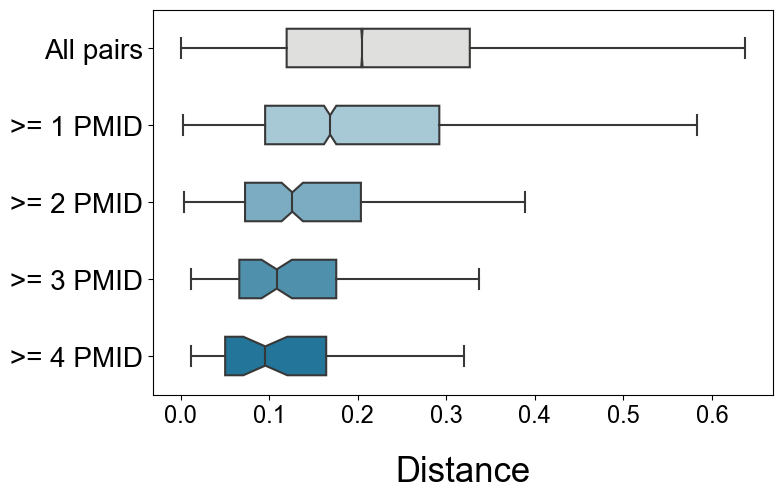

In [31]:
# draw boxplot
plt.figure(figsize=(8, 5))
plt.rcParams['font.sans-serif'] = 'Arial'
sns.boxplot(data=ppi_df, showfliers=False,width=0.5,notch=True,orient='h',
            palette=['#dfdfde','#9fcbdd','#6fb1cd','#3f97bc','#107dac'])
plt.xticks(rotation=0, ha='center',fontsize=17)
plt.yticks(fontsize=20)
plt.xlabel('Distance',fontsize=25,labelpad=20)